In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import sys; sys.version

'3.8.12 | packaged by conda-forge | (default, Oct 12 2021, 21:59:51) \n[GCC 9.4.0]'

In [3]:
from IPython.display import HTML
import matplotlib.animation as anim

from cbf_opt import asif, cbf, dynamics
from refine_cbfs import dynamics as hjr_dynamics, cbf as hjr_cbf
import matplotlib.pyplot as plt
from tqdm import tqdm
from scipy.linalg import solve_continuous_are
import hj_reachability as hj
import jax.numpy as jnp
import numpy as np

In [4]:
# TODO: See whether we can just import this from a plotting_suite
import matplotlib
matplotlib.rcParams.update({
    "pgf.texsystem": "pdflatex",
    'font.family': 'serif',
    'font.size': '32',
    'text.usetex': True,
    'pgf.rcfonts': False,
    'lines.linewidth': 6.,
})

In [5]:
class InvPendulum(dynamics.ControlAffineDynamics):
    def __init__(self, params, **kwargs):
        params['n_dims'] = 2
        params['control_dims'] = 1  # TODO: How to do this correctly?
        super().__init__(params, **kwargs)

    def open_loop_dynamics(self, state, time=0.0):
        return jnp.array([state[1], jnp.sin(state[0])])

    def control_matrix(self, state, time=0.0):
        return jnp.expand_dims(jnp.array([0, 1]), axis=-1)

    def state_jacobian(self, state, control, time=0.0):
        return jnp.array([[0, 1], [jnp.cos(state[0]), 0]])


class InvPendulumNP(dynamics.ControlAffineDynamics):
    def __init__(self, params, **kwargs):
        params['n_dims'] = 2
        params['control_dims'] = 1  # TODO: How to do this correctly?
        super().__init__(params, **kwargs)

    def open_loop_dynamics(self, state, time=0.0):
        return np.array([state[1], np.sin(state[0])])

    def control_matrix(self, state, time=0.0):
        return np.expand_dims(np.array([0, 1]), axis=-1)

    def state_jacobian(self, state, control, time=0.0):
        return np.array([[0, 1], [np.cos(state[0]), 0]])

In [6]:
class InvPendulumCBF(cbf.ControlAffineCBF):
    def __init__(self, dynamics, params, **kwargs):
        super().__init__(dynamics, params, **kwargs)
        self.delta = params["delta"]

    def vf_dt_partial(self, state, time):
        return jnp.atleast_1d(0.)
        
    def vf(self, state, time=0.0):
        return jnp.minimum(1 - state[0] ** 2, 2 - state[1] ** 2)    

    def _grad_vf(self, state, time=0.0):
        if 1 - state[0] ** 2 < 2 - state[1] ** 2:
            return jnp.array([-2 * state[0], 0])
        else:
            return jnp.array([0, -2 * state[1]])


class InvPendulumImplicitCBF(cbf.ControlAffineImplicitCBF):
    def __init__(self, dynamics, params, **kwargs):
        super().__init__(dynamics, params, **kwargs)
        self.delta = params["delta"]
        self.backup_vf_scalar = kwargs.get('backup_vf_scalar', 100)

    def backup_vf(self, state, time=0.0):
        return self.backup_vf_scalar * jnp.minimum((jnp.pi / 12) ** 2 - state[0] ** 2, self.delta ** 2 - state[1] ** 2)

    def safety_vf(self, state, time=0.0):
        return jnp.minimum(1 - state[0] ** 2, 2 - state[1] ** 2)
    
    def _grad_safety_vf(self, state, time=0.0):
        if 1 - state[0] ** 2 < 2 - state[1] ** 2:
            return jnp.array([-2 * state[0], 0])
        else:
            return jnp.array([0, -2 * state[1]])
    
    def _grad_backup_vf(self, state, time=0.0):
        return self.backup_vf_scalar * self._grad_safety_vf(state, time)



class InvPendulumImplicitCBFNP(cbf.ControlAffineImplicitCBF):
    def __init__(self, dynamics, params, **kwargs):
        super().__init__(dynamics, params, **kwargs)
        self.delta = params["delta"]
        self.backup_vf_scalar = kwargs.get('backup_vf_scalar', 100)

    def backup_vf(self, state, time=0.0):
        return self.backup_vf_scalar * np.minimum((np.pi / 12) ** 2 - state[0] ** 2, self.delta ** 2 - state[1] ** 2)

    def safety_vf(self, state, time=0.0):
        return np.minimum(1 - state[0] ** 2, 2 - state[1] ** 2)
    
    def _grad_safety_vf(self, state, time=0.0):
        if 1 - state[0] ** 2 < 2 - state[1] ** 2:
            return np.array([-2 * state[0], 0])
        else:
            return np.array([0, -2 * state[1]])
    
    def _grad_backup_vf(self, state, time=0.0):
        return self.backup_vf_scalar * self._grad_safety_vf(state, time)

In [7]:
class InvPendulumBackupController(cbf.BackupController):

    def __init__(self, dynamics, T_backup, **kwargs):
        super().__init__(dynamics, T_backup, **kwargs)
        self.lqr_term = kwargs.get('F', jnp.zeros((self.dynamics.n_dims, self.dynamics.control_dims)))

    def policy(self, x, t):
        action = -jnp.atleast_1d(self.lqr_term @ x)
        if self.umin is not None:
            action = jnp.maximum(action, self.umin)
        if self.umax is not None:
            action = jnp.minimum(action, self.umax)
        return action
    
    def grad_policy(self, x, t):
        return -self.lqr_term

class InvPendulumBackupControllerNP(cbf.BackupController):

    def __init__(self, dynamics, T_backup, **kwargs):
        super().__init__(dynamics, T_backup, **kwargs)
        self.lqr_term = kwargs.get('F', np.zeros((self.dynamics.n_dims, self.dynamics.control_dims)))

    def policy(self, x, t):
        action = -np.atleast_1d(self.lqr_term @ x)
        if self.umin is not None:
            action = np.maximum(action, self.umin)
        if self.umax is not None:
            action = np.minimum(action, self.umax)
        return action
    
    def grad_policy(self, x, t):
        return -self.lqr_term

In [8]:
inv_pend = InvPendulumNP({'dt': 0.01})
inv_pend_cbf = InvPendulumImplicitCBFNP(inv_pend, params={'delta': 0.1})

In [9]:
A = inv_pend.state_jacobian(jnp.array([0, 0]), jnp.array([0]))
B = inv_pend.control_jacobian(jnp.array([0, 0]), jnp.array([0]))
Q = jnp.eye(2); R = 1e4 * jnp.eye(1)

P = solve_continuous_are(A, B, Q, R)
F = jnp.linalg.inv(R) @ B.T @ P

backup_controller = InvPendulumBackupControllerNP(inv_pend, T_backup=3.5, F=np.array(F), umin=-3, umax=3)

In [10]:
inv_pend_cbf.backup_controller = backup_controller

In [11]:
nominal_policy = lambda x, t: jnp.atleast_1d(2.)

In [12]:
trade_off_filter = asif.TradeoffFilter(inv_pend, inv_pend_cbf, backup_controller, nominal_policy=nominal_policy, beta = 30.)

## Calculating trajectories

In [84]:
x0 = jnp.array([0., 0.])
states = [x0]
control = []

ts = jnp.arange(0, 5, 0.01)

x = x0

for t in ts:  
    input_nom = nominal_policy(x, t)
    x = inv_pend.step(x, input_nom)
    states.append(x)
    control.append(input_nom)

states = jnp.array(states)

In [86]:
from tqdm import tqdm

In [88]:
x0 = np.array([0., 0.])
states_filt = [x0]
control_filt = []

ts = np.arange(0, 5, 0.01)

x = x0

for i, t in enumerate(tqdm(ts)):  
    input_nom = trade_off_filter(x, time=t)
    x = inv_pend.step(x, input_nom)
    states_filt.append(x)
    control_filt.append(input_nom)

states_filt = jnp.array(states_filt)

100%|██████████| 500/500 [00:18<00:00, 26.87it/s]


## Plotting some garbage

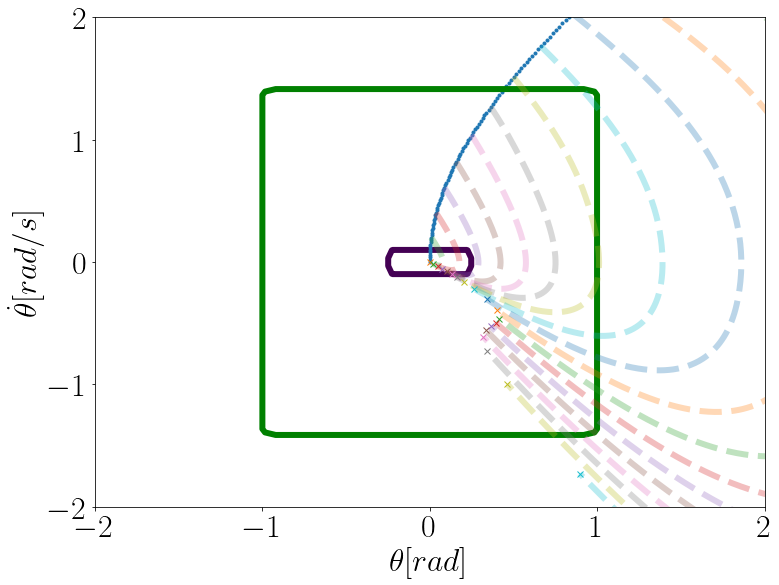

In [89]:
XX1, XX2 = jnp.meshgrid(jnp.linspace(-jnp.pi, jnp.pi, 100), jnp.linspace(-jnp.pi, jnp.pi, 100))
ZZ = inv_pend_cbf.backup_vf(jnp.array([XX1.ravel(), XX2.ravel()]))
ZZ2 = inv_pend_cbf.safety_vf(jnp.array([XX1.ravel(), XX2.ravel()]))

fig, ax = plt.subplots(figsize=(12,9))

plt.contour(XX1, XX2, ZZ.reshape(XX1.shape[0], XX1.shape[1]), levels=[0])
plt.xlim([-2, 2])
plt.ylim([-2, 2])
plt.plot(states[:, 0], states[:, 1], '.')

plt.contour(XX1, XX2, ZZ2.reshape(XX1.shape[0], XX1.shape[1]), levels=[0], colors='g')

plt.ylabel(r"$\dot{\theta}[rad/s]$")
plt.xlabel(r"$\theta[rad]$")



for i in range(states.shape[0] // 10):
    x0 = states[10 * i].copy()
    states_temp, _ = backup_controller.rollout_backup(x0, t0=0)
    p1 = plt.plot(states_temp[:,0], states_temp[:,1], '--', alpha=0.3)
    plt.plot(states_temp[-1,0], states_temp[-1,1], 'x', color=p1[0].get_color())
plt.show()

In [ ]:
fig, ax = plt.subplots(figsize=(12,9))
ax.plot(control_filt, label='Filtered control')
ax.plot(control, label='Nominal control')
ax.set_title('Control input')
ax.legend()

In [13]:
low_bound = jnp.array([-jnp.pi, -jnp.pi])
high_bound = jnp.array([jnp.pi, jnp.pi])
nbr_pts = (100, 100)
grid = hj.Grid.from_lattice_parameters_and_boundary_conditions(hj.sets.Box(low_bound, high_bound), nbr_pts)

inv_pend_tabular_cbf = hjr_cbf.TabularCBF(inv_pend, grid=grid)
inv_pend_tabular_cbf.backup_controller = backup_controller

In [ ]:
backup_controller.policy

In [15]:
inv_pend_tabular_cbf.tabularize_cbf(inv_pend_cbf)

100%|██████████| 100/100 [03:53<00:00,  2.33s/it]


Text(0.5, 0.98, 'Rotary inverted pendulum (2D)')

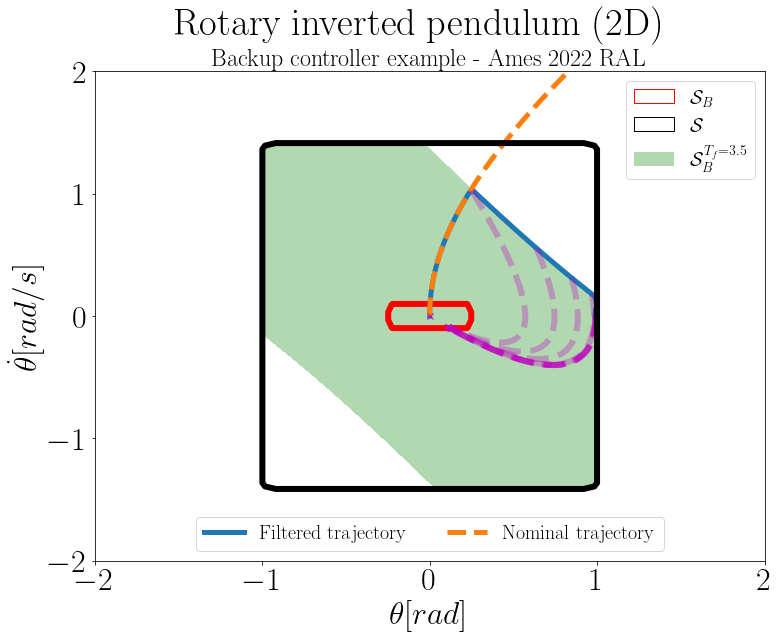

In [90]:
fig, ax = plt.subplots(figsize=(12,9))
cs = ax.contour(XX1, XX2, ZZ.reshape(XX1.shape[0], XX1.shape[1]), levels=[0], colors='r')
proxy = []
proxy += [plt.Rectangle((0,0),1,1,ec = 'r', fc='white') 
         for pc in cs.collections]

ax.set_xlim([-2, 2])
ax.set_ylim([-2, 2])
ax.plot(states_filt[:, 0], states_filt[:, 1], linewidth=5, label="Filtered trajectory")
ax.plot(states[:, 0], states[:, 1], "--", linewidth=5, label="Nominal trajectory")

leg = ax.legend(loc="lower center", prop={"size": 20}, ncol=2)


for i in range(states_filt.shape[0] // 50):
    states_backedup, _ = backup_controller.rollout_backup(states_filt[50 * i])
    ax.plot(states_backedup[:,0], states_backedup[:,1], '--', alpha=0.3, color='m')
    ax.plot(states_backedup[-1,0], states_backedup[-1,1], 'x', color='m')

cs = ax.contour(XX1, XX2, ZZ2.reshape(XX1.shape[0], XX1.shape[1]), levels=[0], colors='k')
proxy += [plt.Rectangle((0,0),1,1,ec = 'k', fc='white') 
         for pc in cs.collections]


cs = ax.contourf(XX1, XX2, inv_pend_tabular_cbf.vf_table.T, levels=[0.01, 2], alpha=0.3, colors='g')
proxy += [plt.Rectangle((0,0),1,1,fc = pc.get_facecolor()[0]) 
         for pc in cs.collections]


ax.set_ylabel(r"$\dot{\theta}[rad/s]$")
ax.set_xlabel(r"$\theta[rad]$")
ax.legend(proxy, ["$\mathcal{S}_B$", "$\mathcal{S}$", "$\mathcal{S}_B^{T_f=3.5}$"], prop={'size': 20})

ax.add_artist(leg)

ax.set_title("Backup controller example - Ames 2022 RAL", fontsize=24)
fig.suptitle("Rotary inverted pendulum (2D)")

## Warmstarting this value function

In [22]:
from hj_reachability import sets
import jax.numpy as jnp

In [23]:
class InvPendulumJNP(dynamics.ControlAffineDynamics):
    # TODO: Find a fix for requiring jnp instead of numpy
    def __init__(self, params, **kwargs):
        params['n_dims'] = 2
        params['control_dims'] = 1
        super().__init__(params, **kwargs)

    def open_loop_dynamics(self, state, time=0.0):
        return jnp.array([state[1], jnp.sin(state[0])])

    def control_matrix(self, state, time=0.0):
        return jnp.expand_dims(jnp.array([0, 1]), axis=-1)

    def state_jacobian(self, state, control, time=0.0):
        return jnp.array([[0, 1], [jnp.cos(state[0]), 0]])

In [24]:
init_value = inv_pend_tabular_cbf.vf_table
obstacle = jnp.minimum(1 - grid.states[..., 0] ** 2, 2 - grid.states[..., 1] ** 2)
backwards_reachable_tube = lambda obstacle: (lambda t, x: jnp.minimum(x, obstacle))
solver_settings = hj.SolverSettings.with_accuracy("very_high",
                                                  value_postprocessor=backwards_reachable_tube(obstacle))

In [25]:
inv_pend_jnp = InvPendulumJNP({'dt': 0.01})
dyn_reachability = hjr_dynamics.HJControlAffineDynamics(inv_pend_jnp, control_space=sets.Box(jnp.array([-3.]), jnp.array([3.])))

In [26]:
time = 0.
target_time = -2.0
times = jnp.linspace(time, target_time, 101)
target_values = hj.solve(solver_settings, dyn_reachability, grid, times, init_value)

100%|##########|  2.0000/2.0 [00:02<00:00,  1.39s/sim_s]


In [27]:
orig_hjr_target_values = hj.solve(solver_settings, dyn_reachability, grid, times, obstacle)

100%|##########|  2.0000/2.0 [00:02<00:00,  1.31s/sim_s]


In [ ]:
dyn_reachability.control_space

In [29]:
times[i]

DeviceArray(-0.19999999, dtype=float32)

In [36]:
import seaborn as sns

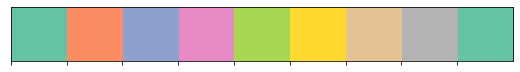

In [78]:
sns.palplot(gen_colors)

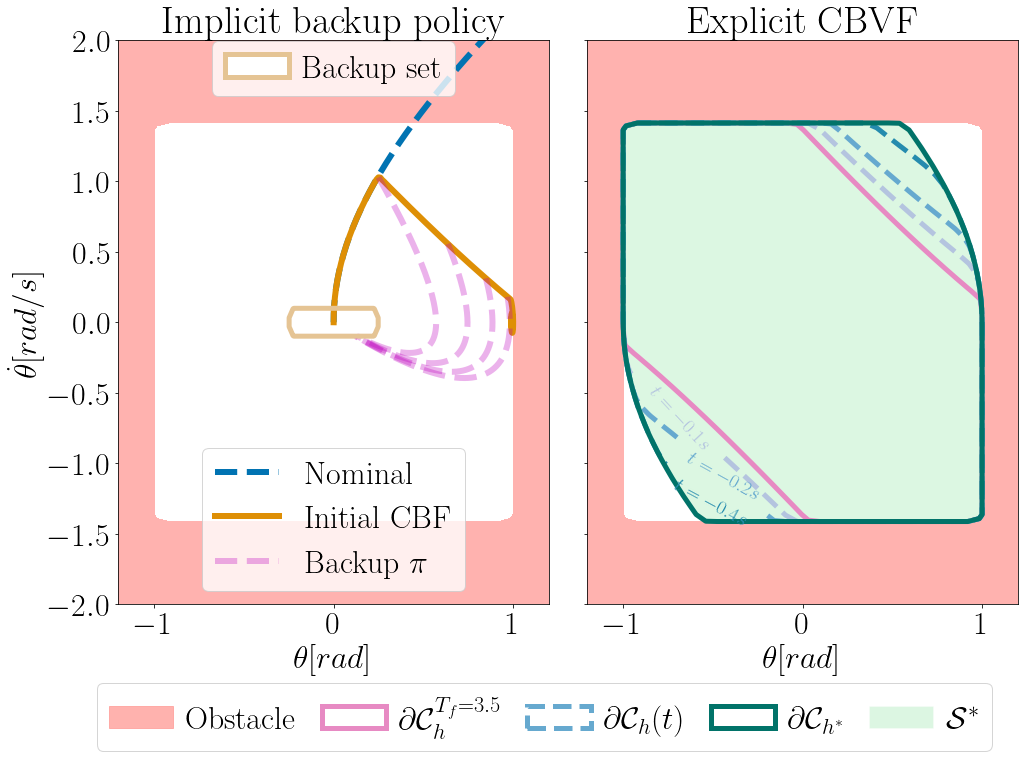

In [133]:
i = 10
fig, axs = plt.subplots(1, 2, figsize=(15,10.25), sharey=True)
blue_colors = sns.color_palette("PuBuGn", 5).as_hex()
gen_colors = sns.color_palette("Set2", 9).as_hex()
alt_colors = sns.color_palette("pastel", 9).as_hex()
ZZ = inv_pend_cbf.backup_vf(jnp.array([grid.states[..., 0].ravel(), grid.states[..., 1].ravel()])).reshape(grid.states[..., 0].shape)

ax = axs[0]
ax.set_ylabel(r"$\dot{\theta}[rad/s]$")
sns.set_palette("colorblind")
# cs = ax.contour(grid.coordinate_vectors[0], grid.coordinate_vectors[1], init_value.T, levels=[0], colors=gen_colors[3], linewidths=5)
ax.plot(states[:, 0], states[:, 1], "--", label="Nominal")
ax.plot(states_filt[:, 0], states_filt[:, 1], label="Initial CBF")




for i in range(states_filt.shape[0] // 50):
    states_backedup, _ = backup_controller.rollout_backup(states_filt[50 * i])
    if i == 0:      
        ax.plot(states_backedup[:,0], states_backedup[:,1], '--', alpha=0.3, color='m', label="Backup $\pi$")
    elif i < 5:
        ax.plot(states_backedup[:,0], states_backedup[:,1], '--', alpha=0.3, color='m', label="_nolegend_")
#     ax.plot(states_backedup[-1,0], states_backedup[-1,1], 'x', color='m')

proxy = [] 
cs = ax.contourf(grid.coordinate_vectors[0], grid.coordinate_vectors[1], obstacle.T, levels=[-10, 0], colors=alt_colors[3], alpha=0.8)
cs = ax.contour(grid.coordinate_vectors[0], grid.coordinate_vectors[1], ZZ.T, levels=[0], colors=gen_colors[6], linewidths=5)
proxy += [plt.Rectangle((0,0),1,1, ec=gen_colors[6], fc='white', lw=5) for pc in cs.collections]
ax.set_xlim([-1.2, 1.2])
ax.set_xlabel(r"$\theta[rad]$")
leg2 = ax.legend(loc="center", bbox_to_anchor=(.5, .15))
leg = ax.legend(proxy, ["Backup set"], loc='center', bbox_to_anchor=(.5, .95), columnspacing=.8, handletextpad=0.4)
ax.add_artist(leg2)
ax.set_title('Implicit backup policy')
ax = axs[1]
# cs = ax.contour(grid.coordinate_vectors[0], grid.coordinate_vectors[1], ZZ.T, levels=[0], colors=gen_colors[6])
proxy = [] 
# proxy += [plt.Rectangle((0,0),1,1, ec=gen_colors[6], fc='white', lw=5) for pc in cs.collections]
# cs = ax.contourf(grid.coordinate_vectors[0], grid.coordinate_vectors[1], obstacle.T, levels=[-10, 0], colors=gen_colors[5], alpha=0.8)

cs = ax.contourf(grid.coordinate_vectors[0], grid.coordinate_vectors[1], obstacle.T, levels=[-10, 0], colors=alt_colors[3], alpha=0.8)
proxy += [plt.Rectangle((0,0),1,1, fc=alt_colors[3], ec=alt_colors[3], alpha=0.8) for pc in cs.collections]
cs = ax.contourf(grid.coordinate_vectors[0], grid.coordinate_vectors[1], orig_hjr_target_values[-1].T, levels=[0, 10], colors=alt_colors[2], alpha=0.3)

cs = ax.contour(grid.coordinate_vectors[0], grid.coordinate_vectors[1], init_value.T, levels=[0], colors=gen_colors[3], linewidths=5)
proxy += [plt.Rectangle((0,0),1,1,ec = gen_colors[3], fc='white', lw=5)
        for pc in cs.collections]

cs = ax.contour(grid.coordinate_vectors[0], grid.coordinate_vectors[1], target_values[5].T, levels=[0], colors=blue_colors[1], linestyles='dashed', linewidths=5)
contourlabel0 = ax.clabel(cs, inline=True, fontsize=20, fmt='$t=-0.1s$', inline_spacing=-22, manual=[(-.6,-.5)])
# for l in contourlabel0:
#         l.set_va('top')

cs = ax.contour(grid.coordinate_vectors[0], grid.coordinate_vectors[1], target_values[10].T, levels=[0], colors=blue_colors[2], linestyles='dashed', linewidths=5)
contourlabel0 = ax.clabel(cs, inline=True, fontsize=20, fmt='$t=-0.2s$', inline_spacing=-22, manual=[(-.4,-1)])
cs = ax.contour(grid.coordinate_vectors[0], grid.coordinate_vectors[1], target_values[20].T, levels=[0], colors=blue_colors[3], linestyles='dashed', linewidths=5)
contourlabel0 = ax.clabel(cs, inline=True, fontsize=20, fmt='$t=-0.4s$', inline_spacing=-22, manual=[(-.4,-1)])
proxy += [plt.Rectangle((0,0),1,1,ec = blue_colors[2], fc='white', linestyle='dashed', lw=5)
        for pc in cs.collections]

cs = ax.contour(grid.coordinate_vectors[0], grid.coordinate_vectors[1], target_values[-1].T, levels=[0], colors=blue_colors[-1], linewidths=5)
# ax.contour(grid.coordinate_vectors[0], grid.coordinate_vectors[1], target_values[80].T, levels=[0], colors='g')

proxy += [plt.Rectangle((0,0),1,1,ec = blue_colors[-1], fc='white', lw=5)
        for pc in cs.collections]


ax.set_xlabel(r"$\theta[rad]$")


proxy += [plt.Rectangle((0,0),1,1,fc = alt_colors[2], ec='white', alpha=0.3)
        for pc in cs.collections]
ax.set_xlim([-1.2, 1.2])
ax.set_ylim([-2, 2])
ax.set_title('Explicit CBVF')
fig.tight_layout()
ax.legend(proxy, ["Obstacle", "$\partial \mathcal{C}_h^{T_f=3.5}$", "$\partial \mathcal{C}_h(t)$", "$\partial \mathcal{C}_{h^*}$", "$\mathcal{S}^*$"], ncol=6, loc='center', bbox_to_anchor=(-0.1, -0.2), columnspacing=.8, handletextpad=0.4)
fig.savefig("backup_cbf/backup_cbf_target_values.pdf", bbox_inches='tight')

In [ ]:
def visualize_evolution(value_function, file_name=None):

    fig, ax = plt.subplots(figsize=(12,9))

    proxy = [] 

    cs = ax.contour(grid.coordinate_vectors[0], grid.coordinate_vectors[1], ZZ, levels=[0], colors='r')
    proxy += [plt.Rectangle((0,0),1,1,ec = 'r', fc='white') 
            for pc in cs.collections]

    cs = ax.contour(grid.coordinate_vectors[0], grid.coordinate_vectors[1], init_value, levels=[0], colors='b')
    proxy += [plt.Rectangle((0,0),1,1,ec = 'b', fc='white') 
            for pc in cs.collections]

    cs = ax.contour(grid.coordinate_vectors[0], grid.coordinate_vectors[1], obstacle.T, levels=[0], colors='k')
    proxy += [plt.Rectangle((0,0),1,1,ec = 'k', fc='white') for pc in cs.collections]

    cont = ax.contour(grid.coordinate_vectors[0], grid.coordinate_vectors[1], value_function[0].T, levels=[0], colors='g')
    proxy += [plt.Rectangle((0,0),1,1,ec = 'g', fc='white')
            for pc in cont.collections]
    ax.contour(grid.coordinate_vectors[0], grid.coordinate_vectors[1], value_function[-1].T, levels=[0], colors='orange')
    ax.grid()

    ax.legend(proxy, ["$\mathcal{S}_B$", "$\mathcal{C}_{implicit}$", "Safe set", "$\mathcal{C}(t)$"], prop={'size': 20})

    ax.set_ylabel(r"$\dot{\theta}[rad/s]$")
    ax.set_xlabel(r"$\theta[rad]$")

    ax.set_title("Backup controller example - Ames 2022 RAL", fontsize=24)
    fig.suptitle("Rotary inverted pendulum (2D)")

    def render_frame(i, colorbar=False):
        global cont

        for c in cont.collections:
            c.remove()
        
        cont = ax.contour(grid.coordinate_vectors[0], grid.coordinate_vectors[1], value_function[i].T, levels=[0], colors='g')
        

    render_frame(0, False)
    animation = anim.FuncAnimation(fig, render_frame, value_function.shape[0], interval=50)
    if filename is not None:
        animation.save(filename)